# 패럿 3조 
#### 권예진, 신동호, 조민석, 조수민
#### 멘토 : 한성환

#### 1. 피드백 포함 데이터 전처리
* 인플레이션을 고려한 income 수정
* 모든 feature에 대한 데이터 검토 후 전처리 
* 무직자와 재직자 분류

## 2. 가설 설정
* 재직자의 경우 : company size가 income에 큰 영향을 준다
* 무직자의 경우 : family member가 income에 큰 영향을 준다

## 2. 모델 생성
* XGBoost, LightGBM,Catboost

#### 3. 모델 결과에 따른 데이터 전처리 재 진행
* age와 company 

#### 4. 모델 완성
* Ensemble 이용

#### 5. 결론 

In [75]:
from google.colab import drive
#필요한 파일 드라이브에 올려놓고 다운로드 받기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install --upgrade joblib
!pip install --upgrade pycaret
!pip install catboost
import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.read_csv('/content/drive/MyDrive/1/Kor_income.csv')
cpi_df = pd.read_excel('/content/drive/MyDrive/1/Kor_cpi.xlsx')

# 전처리 진행

In [78]:
#필요없는 칼럼 삭제
del df['Unnamed: 0']
del df['id']
del df['wave']
del df['religion']
#year age로 바꾸기
df['year_born'] = df['year']-df['year_born']+1
df.rename(columns={'year_born' : 'age'}, inplace = True)

In [79]:
cpi_df.rename(columns={'소비자물가 총지수(2020=100)' : 'cpi'}, inplace = True)
#통계청 자료 전처리
cpi_df = cpi_df.iloc[[1, 2], :]
cpi_df = cpi_df.dropna(axis=1)
cpi_df = cpi_df.T
cpi_df = cpi_df.reset_index(drop=True)
cpi_df.columns = ["year", "cpi"]
cpi_df['year'] = cpi_df['year'].astype(int)
cpi_df['cpi'] = cpi_df['cpi'].astype(float)

In [80]:
cpi_dict = cpi_df.set_index('year')['cpi'].to_dict()
# 인플레이션 적용
cpi_2020 = 100.0 #기준

# 인플레이션 데이터를 딕셔너리 형태로 변환
cpi_dict = dict(zip(cpi_df["year"], cpi_df["cpi"]))

# 인플레이션을 고려해 income 데이터를 수정
for index, row in df.iterrows():
    year = row["year"]
    income = row["income"]
    inflation_rate = cpi_2020 / cpi_dict[year]
    df.at[index, "income"] = income * inflation_rate

#income 최저를 0으로.
df=df[df['income']>=0]
df['income'].min()

0.0

<Axes: ylabel='income'>

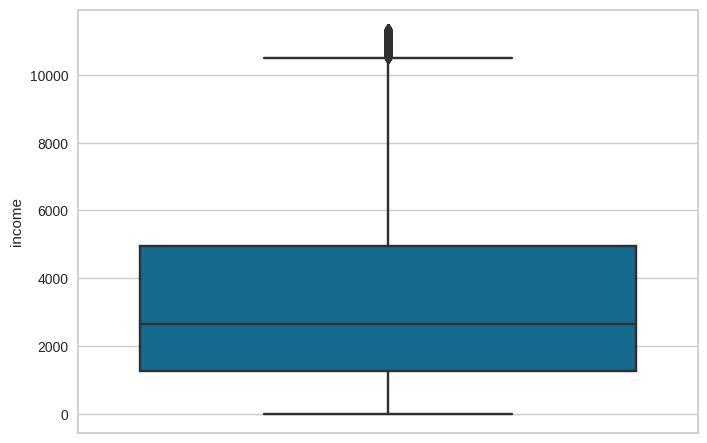

In [81]:
#이상치 정리
Q1 = df['income'].quantile(0.25) #income에서 1분위 계산
Q3 = df['income'].quantile(0.75) #income에서 3분위 계산
IQR = Q3 - Q1
df = df[(df['income'] >= Q1 - 1.5*IQR) & (df['income'] <= Q3 + 1.5*IQR)] #이상치 제거 진행

sns.boxplot(x=None, y="income", data=df)

In [82]:
#공백을 결측치로
df.replace(' ', np.nan, inplace=True)

In [83]:
#occupation 정리
df.drop(df[df['occupation'] == 9999].index, inplace=True)
df['occupation'] = df['occupation'].str[0]
df['occupation'].unique()

array(['6', nan, '5', '9', '2', '8', '4', '7', '3', '1'], dtype=object)

In [84]:
#나이 분류로
age_ranges = [19, 25, 30, 35, 40, 50, 60, np.inf]
age_labels = ['19-24', '25-29', '30-34', '35-39', '40-49', '50-59', '60+']

df['age'] = pd.cut(df['age'], bins=age_ranges, labels=age_labels, right=False)

In [85]:
#marriage 처리
df.drop(df[df['marriage'] == 9].index, inplace=True)
df.drop(df[df['marriage'] == 0].index, inplace=True)

In [86]:
df['marriage'].replace({4:3}, inplace = True)
df['marriage'].unique()

array([2, 1, 3, 5, 6])

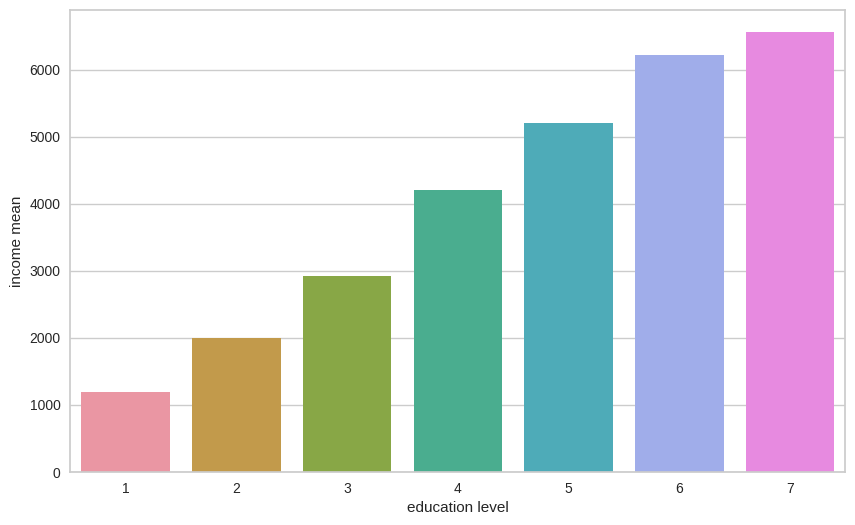

In [87]:
#education level 정리
df['education_level'] = df['education_level'].replace({7:6})
df['education_level'] = df['education_level'].replace({2:1, 3:2, 4:3, 5:4, 6:5, 8:6, 9:7})
plt.figure(figsize=(10, 6))
sns.barplot(x='education_level', y='income', data=df, ci=None)
plt.xlabel('education level')
plt.ylabel('income mean')
plt.show()

In [88]:
#region 정리 (수도권/지방권)
df['region'] = df['region'].apply(lambda x: 1 if int(x) in [1,2] else 0)

In [153]:
del df['company_size']

## 무직자/재직자 따로 데이터 전처리

In [154]:
#재직자 데이터 프레임 따로 제작
df_w = df[(~df['occupation'].isna()) & (df['reason_none_worker'].isna())]
del df_w['reason_none_worker']
del df_w['year']

In [155]:
# #company size 정리
# df_w['company_size'] = df_w['company_size'].astype('int')
# throw_index = df_w[df_w['company_size']==99].index
# df_w = df_w.drop(throw_index)
# df_w['company_size'].unique()

In [156]:
# df_w['company_size'] = df_w['company_size'].replace({11: 1})

In [157]:
# def categorize_company_size(row):
#     if row['income'] <= 4000:
#         return 1
#     elif row['income'] <= 4500:
#         return 2
#     elif row['income']<= 5000:
#         return 3
#     elif row['income']<=5500:
#         return 4
#     elif row['income']<=6000:
#         return 5
#     else:
#         return 6

# df_w['company_size'] = df_w.apply(categorize_company_size, axis=1)
# df_w['company_size'] = df_w['company_size'].apply(pd.to_numeric)
# df_w.info()

In [210]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47332 entries, 0 to 78927
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           47332 non-null  object 
 1   family_member    47332 non-null  int64  
 2   gender           47332 non-null  object 
 3   age              47332 non-null  object 
 4   education_level  47332 non-null  int64  
 5   marriage         47332 non-null  object 
 6   occupation       47332 non-null  object 
 7   income           47332 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [211]:
#무직자 데이터 프레임 따로 제작
df_n = df[(df['occupation'].isna()) & (~df['reason_none_worker'].isna())]
del df_n['occupation']
del df_n['year']
del df_n['family_member']

In [212]:
#reason_non_worker 정리
df_n.drop(df_n[df_n['reason_none_worker'] == '99'].index, inplace=True)
df_n.drop(df_n[df_n['reason_none_worker'] == '0'].index, inplace=True)

In [213]:
df_w['education_level']=df_w['education_level'].replace({7:6})

## Categorical encoding

In [214]:
w_category = ['region', 'marriage', 'occupation', 'gender','age']
df_w[w_category] = df_w[w_category].astype('object')
w_num=['family_member', 'education_level']

n_category = ['region', 'marriage', 'reason_none_worker', 'gender', 'age']
n_num=['education_level']
df_n[n_category] = df_n[n_category].astype('object')

<Axes: >

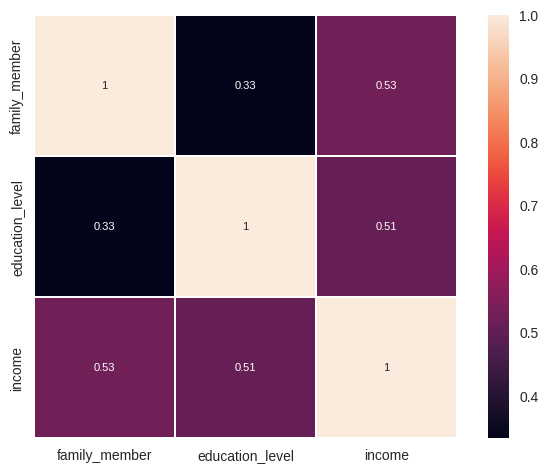

In [215]:
corr = df_w.corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

<Axes: >

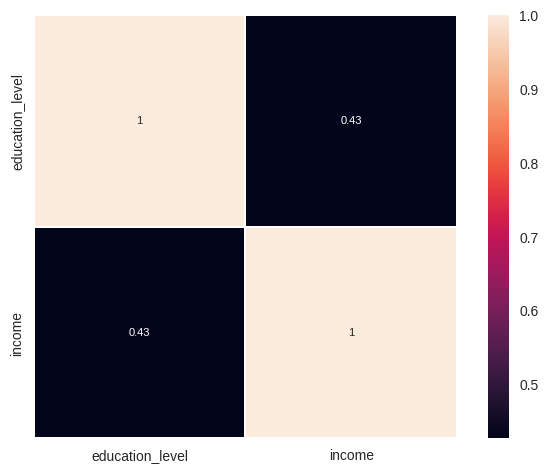

In [216]:
corr = df_n.corr()
sns.heatmap(corr, linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True, annot_kws = {'size':8})

In [217]:
df_w_dum = pd.get_dummies(df_w[w_category])
df_n_dum = pd.get_dummies(df_n[n_category])

In [218]:
data_w = pd.DataFrame()
data_w = pd.concat([df_w_dum, df_w[w_num], df_w['income']], axis=1)

In [219]:
data_n = pd.DataFrame()
data_n = pd.concat([df_n_dum, df_n[n_num], df_n['income']], axis=1)

# 모델 

In [220]:
seed = 42
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from pycaret.regression import *

In [221]:
from sklearn.preprocessing import StandardScaler

x_w = data_w.drop(columns=['income'], axis=1)
y_w = data_w['income']

xw_train, xw_test, yw_train, yw_test = train_test_split(x_w,
                                                    y_w,
                                                    test_size=0.3,
                                                    random_state=seed)

#print(xw_train.shape, yw_train.shape)

ss = StandardScaler() # 정규화를 위한 과정입니다.
xw_train = ss.fit_transform(xw_train)
xw_test = ss.fit_transform(xw_test)

In [222]:
x_n = data_n.drop(columns=['income'], axis=1)
y_n = data_n['income']

xn_train, xn_test, yn_train, yn_test = train_test_split(x_n,
                                                    y_n,
                                                    test_size=0.3,
                                                    random_state=seed)

#print(xn_train.shape, yn_train.shape)

ss = StandardScaler() # 정규화를 위한 과정입니다.
xn_train = ss.fit_transform(xn_train)
xn_test = ss.fit_transform(xn_test)

## XGboost

In [223]:
import xgboost as xgb

### 재직자의 경우

In [224]:
model_w = xgb.XGBRegressor()

model_w.fit(xw_train, yw_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [225]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'], # 건들지 말아주세요
              'learning_rate': [0.05], 
              'max_depth': [15],
              'min_child_weight': [4],
              'subsample': [0.8],
              'colsample_bytree': [0.5],
              'n_estimators': [130],
              
             }

xgb_grid_w = GridSearchCV(xgb1,
                         parameters,
                         cv = 2,
                         n_jobs = 5,
                         verbose=True)
                        
xgb_grid_w.fit(xw_train,
               yw_train)

print(xgb_grid_w.best_score_)
print(xgb_grid_w.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[05:50:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0.5119755760644336
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators': 130, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.8}


In [226]:
best_pars_w = xgb_grid_w.best_params_
best_model_w = xgb_grid_w.best_estimator_

In [227]:
y_pred_w = xgb_grid_w.predict(xw_test)
RMSE_w = mean_squared_error(yw_test, y_pred_w)**0.5
RMSE_w

1796.8993194685943

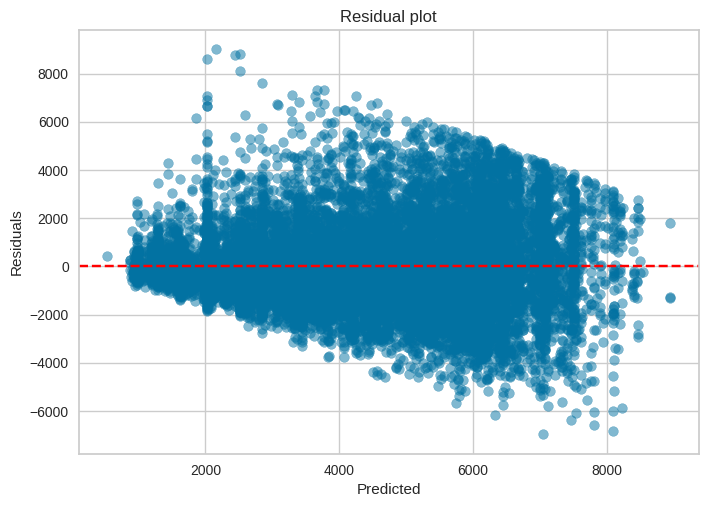

In [228]:
# 예측값과 실제값의 residual 계산
residuals = yw_test - y_pred_w

# # residual plot 그리기
plt.scatter(y_pred_w, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [229]:
# pickled binary file 형태로 저장된 객체를 로딩한다
file_name = 'xgboost_worker.pkl'
joblib.dump(xgb_grid_w, file_name)

['xgboost_worker.pkl']

### 무직자의 경우

In [230]:
model_n = xgb.XGBRegressor()

model_n.fit(xn_train, yn_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [231]:
xgb2 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'], # 건들지 말아주세요
              'learning_rate': [0.05 ], 
              'max_depth': [5],
              'min_child_weight': [5],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200],
              
             }

xgb_grid_n = GridSearchCV(xgb2,
                         parameters,
                         cv = 2,
                         n_jobs = 5,
                         verbose=True)

xgb_grid_n.fit(xn_train,
               yn_train)

print(xgb_grid_n.best_score_)
print(xgb_grid_n.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[05:50:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0.3081449102720652
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.8}


In [232]:
best_pars_n = xgb_grid_n.best_params_

best_model_n = xgb_grid_n.best_estimator_

In [233]:
y_pred_n = xgb_grid_n.predict(xn_test)
RMSE_n = mean_squared_error(yn_test, y_pred_n)**0.5
RMSE_n

1282.7003896804024

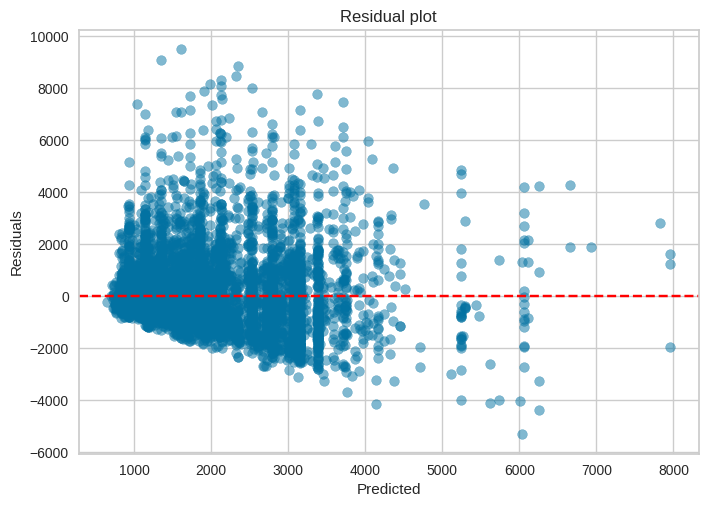

In [234]:
# 예측값과 실제값의 residual 계산
residuals_n = yn_test - y_pred_n

# residual plot 그리기
plt.scatter(y_pred_n, residuals_n, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [235]:
#파일 저장
file_name = 'xgboost_non_worker.pkl'
joblib.dump(xgb_grid_n, file_name)

['xgboost_non_worker.pkl']

## lightGBM

### 재직자의 경우

In [236]:
import lightgbm as lgb

model_l = lgb.LGBMRegressor()

param_l = {
        'boosting_type': ['gbdt'],
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [0.1],
        'max_depth': [-1],
        'min_child_samples': [20],
        'min_child_weight': [0.001],
        'min_split_gain': [0.0],
        'n_estimators': [100],
        'n_jobs': [-1],
        'num_leaves': [31],
        'objective': ['regression'],# 이건 건들지 말아주세요
        'random_state': [42],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'subsample': [1.0],
        'subsample_for_bin': [200000],
        'subsample_freq': [0],
        'usegpu': [True],
        'metric': ['rmse']  # 평가지표입니다. 건들지 말아ㅜㅈ세요
        }

lgb_grid = GridSearchCV(model_l,
                        param_l,
                        cv=5,
                        n_jobs=-1,
                        verbose=2,
                        scoring='neg_root_mean_squared_error')

In [237]:
lgb_grid.fit(xw_train, yw_train)
# print(lgb_grid.best_params_)
# print(lgb_grid.best_score_ * -1)

y_pred_w_l = lgb_grid.predict(xw_test)
RMSE_l = mean_squared_error(yw_test, y_pred_w_l)**0.5
RMSE_l

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Unknown parameter: usegpu


1808.742295719779

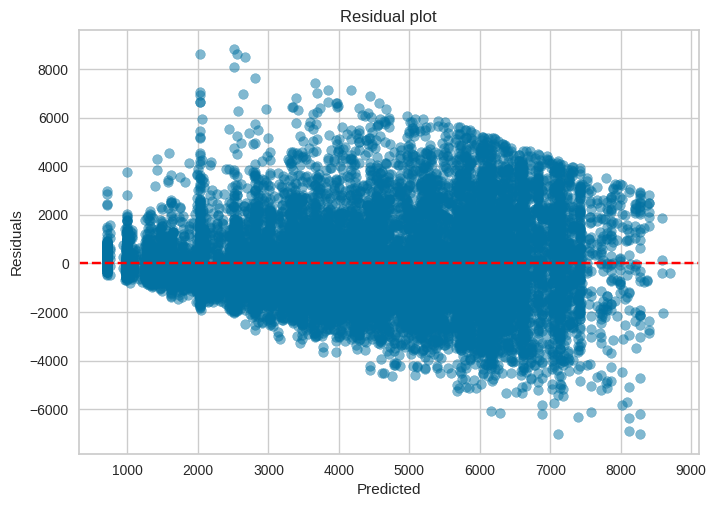

In [238]:
# 예측값과 실제값의 residual 계산
residuals_w_l = yw_test - y_pred_w_l

# residual plot 그리기
plt.scatter(y_pred_w_l, residuals_w_l, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [239]:
#파일 저장
file_name = 'lightgbm_worker.pkl'
joblib.dump(lgb_grid, file_name)

['lightgbm_worker.pkl']

### 무직자의 경우

In [240]:
import lightgbm as lgb

model_l_n = lgb.LGBMRegressor()

param_l_n = {
 'boosting_type': ['gbdt'],
 'class_weight': [None],
 'colsample_bytree': [1.0],
 'importance_type': ['split'],
 'learning_rate': [0.1],
 'max_depth': [-1],
 'min_child_samples': [20],
 'min_child_weight': [0.001],
 'min_split_gain': [0.0],
 'n_estimators': [100],
 'n_jobs': [-1],
 'num_leaves': [31],
 'objective': ['regression'],
 'random_state': [42],
 'reg_alpha': [0.0],
 'reg_lambda': [0.0],
 'silent': ['warn'],
 'subsample': [1.0],
 'subsample_for_bin': [200000],
 'subsample_freq': [0],
 'usegpu': [True],
 'metric': ['rmse']  # 평가지표입니다. 건들지 말아ㅜㅈ세요
}

lgb_grid_n = GridSearchCV(model_l_n,
                        param_l,
                        cv=5,
                        n_jobs=-1,
                        verbose=2,
                        scoring='neg_root_mean_squared_error')

In [241]:
lgb_grid_n.fit(xn_train, yn_train)
# print(lgb_grid.best_params_)
# print(lgb_grid.best_score_ * -1)
y_pred_n_l = lgb_grid_n.predict(xn_test)
RMSE_l_n = mean_squared_error(yn_test, y_pred_n_l)**0.5
RMSE_l_n

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Unknown parameter: usegpu


1286.8494789997367

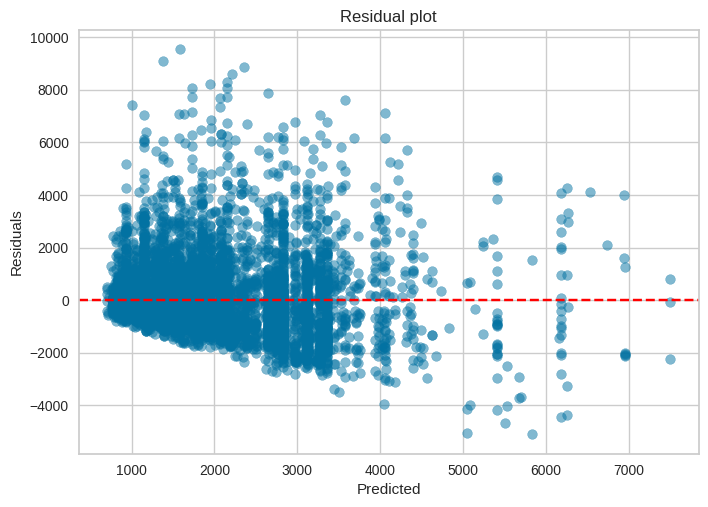

In [242]:
# 예측값과 실제값의 residual 계산
residuals_n_l = yn_test - y_pred_n_l

# residual plot 그리기
plt.scatter(y_pred_n_l, residuals_n_l, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [243]:
#파일 저장
file_name = 'lightgbm_non_worker.pkl'
joblib.dump(lgb_grid_n, file_name)

['lightgbm_non_worker.pkl']

## CatBoost

### 재직자의 경우

In [244]:
from catboost import CatBoostRegressor, Pool

model_c = CatBoostRegressor()
param_c = {
    'learning_rate': [0.01],
    'n_estimators': [800],
    'max_depth': [13],
    'loss_function': ['RMSE'],  # 평가지표입니다. 건들지 말아주세요.
    'colsample_bylevel': [0.9]
    }
cat_grid = GridSearchCV(model_c,
                        param_c,
                        cv=5,
                        n_jobs=-1,
                        verbose=2,
                        scoring='neg_root_mean_squared_error')

In [245]:
cat_grid.fit(xw_train, yw_train)
print(cat_grid.best_params_)
print(cat_grid.best_score_ * -1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2589.2826343	total: 6.97ms	remaining: 5.57s
1:	learn: 2577.2107115	total: 45.6ms	remaining: 18.2s
2:	learn: 2566.8315596	total: 50.5ms	remaining: 13.4s
3:	learn: 2555.0272281	total: 75.5ms	remaining: 15s
4:	learn: 2543.5053144	total: 101ms	remaining: 16s
5:	learn: 2532.5288881	total: 110ms	remaining: 14.5s
6:	learn: 2521.4512399	total: 134ms	remaining: 15.2s
7:	learn: 2510.7876472	total: 141ms	remaining: 14s
8:	learn: 2499.5625350	total: 165ms	remaining: 14.5s
9:	learn: 2488.9566742	total: 190ms	remaining: 15s
10:	learn: 2478.5004044	total: 220ms	remaining: 15.8s
11:	learn: 2468.1556714	total: 234ms	remaining: 15.3s
12:	learn: 2457.7723972	total: 258ms	remaining: 15.6s
13:	learn: 2447.6554807	total: 282ms	remaining: 15.8s
14:	learn: 2437.6577279	total: 302ms	remaining: 15.8s
15:	learn: 2428.0499662	total: 316ms	remaining: 15.5s
16:	learn: 2418.3395881	total: 340ms	remaining: 15.6s
17:	learn: 2408.5433462	total: 364ms	

In [246]:
y_pred_c_w = cat_grid.predict(xw_test)
RMSE_c_w = mean_squared_error(yw_test, y_pred_c_w)**0.5
RMSE_c_w

1794.3179507355676

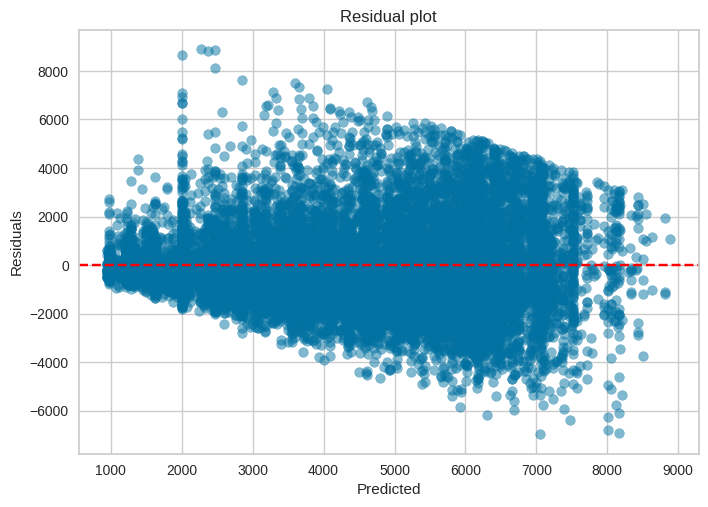

In [247]:
# 예측값과 실제값의 residual 계산
residuals_w_c = yw_test - y_pred_c_w

# residual plot 그리기
plt.scatter(y_pred_c_w, residuals_w_c, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [248]:
#파일 저장
file_name = 'catboost_worker.pkl'
joblib.dump(cat_grid, file_name)

['catboost_worker.pkl']

### 무직자의 경우

In [249]:
model_c_n = CatBoostRegressor()
param_c_n = {
    'learning_rate': [0.001, 0.1,0.3],
    'n_estimators': [100,500,1000],
    'max_depth': [4,8,12],
    'loss_function': ['RMSE'],  # 평가지표입니다. 건들지 말아주세요.
    'colsample_bylevel': [0.5]
}
cat_grid_n = GridSearchCV(model_c_n,
                        param_c_n,
                        cv=5,
                        n_jobs=-1,
                        verbose=2,
                        scoring='neg_root_mean_squared_error')

In [ ]:
cat_grid_n.fit(xn_train, yn_train)
#print(cat_grid.best_params_)
#print(cat_grid.best_score_ * -1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
y_pred_c_n = cat_grid_n.predict(xn_test)
RMSE_c_n = mean_squared_error(yn_test, y_pred_c_n)**0.5
RMSE_c_n

In [ ]:
# 예측값과 실제값의 residual 계산
residuals_n_c = yn_test - y_pred_c_n

# residual plot 그리기
plt.scatter(y_pred_c_n, residuals_n_c, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

In [ ]:
#파일 저장
file_name = 'catboost_non_worker.pkl'
joblib.dump(cat_grid_n, file_name)

## 앙상블

### 재직자의 경우

In [ ]:
# pickled binary file 형태로 저장된 객체를 로딩한다
xgb_name = 'xgboost_worker.pkl'
lgb_name = 'lightgbm_worker.pkl'
cat_name = 'catboost_worker.pkl'
xgb = joblib.load(xgb_name)
lgb = joblib.load(lgb_name)
cat = joblib.load(cat_name)

In [ ]:
from copy import deepcopy

class worker_model():
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        sum = 0
        for model in self.models:
            sum += model.predict(x)
        return sum / len(self.models)

In [ ]:
final_model = worker_model([xgb, lgb, cat])
y_pred = final_model.predict(xw_test)
RMSE = mean_squared_error(yw_test, y_pred)**0.5
RMSE

### 무직자의 경우

In [ ]:
# pickled binary file 형태로 저장된 객체를 로딩한다
xgbn_name = 'xgboost_non_worker.pkl'
lgbn_name = 'lightgbm_non_worker.pkl'
catn_name = 'catboost_non_worker.pkl'
xgb_n = joblib.load(xgbn_name)
lgb_n = joblib.load(lgbn_name)
cat_n = joblib.load(catn_name)

In [ ]:
from copy import deepcopy

class non_worker_model():
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        sum = 0
        for model in self.models:
            sum += model.predict(x)
        return sum / len(self.models)

In [ ]:
final_model = non_worker_model([xgb_n, lgb_n, cat_n])
yn_pred_f = final_model.predict(xn_test)
RMSE = mean_squared_error(yn_test, yn_pred_f)**0.5
RMSE

In [ ]:
# 예측값과 실제값의 residual 계산
residuals_n_f = yn_test - yn_pred_f

# residual plot 그리기
plt.scatter(yn_pred_f, residuals_n_f, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# TEST

## 재직자의 경우

## 무직자의 경우